# Threshold determination analysis

We want to find the optimal threshold for the inclusion probability of scCODA.
Benchmark details see paper.

In [6]:
# Setup
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pickle as pkl

import paper_simulation_scripts.benchmark_utils as util

Preparation:

We apply every threshold in $\{0.01, ..., 0.99\}$ to the results determined by scCODA and
then calculate the according classification statistics (mcc, true positive rate, true negative rate, false discovery rate, ...)

The output will be a dictionary with one DataFrame for every threshold

In [7]:
# Get file names
save_path = "../data/threshold_determination/threshold_determination_005_balanced/"
files = os.listdir(save_path)

# Thresholding inclusion probabilities

def recalculate_inc_prob(inc_probs, threshold):
    return [p > threshold for p in inc_probs]

In [8]:
# Prepare output: Dict with one df for each threshold that contains evaluation of all datasets
sim_columns = ['n_cell_types', 'n_cells', 'n_controls',
               'n_cases', 'Base', 'Increase',
               'log-fold increase', 'b_true', 'w_true']

thresholds = np.round(np.arange(0.01, 1., 0.01), 2)

Fill the dictionary, one result file at a time.
A file contains the result of scCODA on all 20 generated datasets with identical parameters
(see *data_generation* for more details on parameter values)

In [9]:
def apply_thresholds_to_results(files, thresholds):
    threshold_dict = {}
    for t in thresholds:
        threshold_dict[t] = pd.DataFrame(columns=sim_columns + ["threshold", "tp", "tn", "fp", "fn"])
    i = 1
    
    # Iterate Over all files
    for file in files:
        if i%10 == 0:
            print(f"file {i}/{len(files)}")
        
        # open file
        with open(save_path + file, "rb") as f:
            d = pkl.load(f)
        
        # For each threshold
        for t in thresholds:
            
            # Prepare df to append to threshold_dict entry
            out_df = d["results"].loc[:, sim_columns]
            out_df["threshold"] = t
            
            tp_list = []
            tn_list = []
            fp_list = []
            fn_list = []
            
            # Iterate over all datasets in file
            for eff in d["effects"]:
                
                # no. of cell types
                K = eff.shape[0]
                ks = list(range(K))[1:]
                
                # calculate significances
                is_significant = recalculate_inc_prob(eff["Inclusion probability"], t)
                
                # Get tp, tn, fp, fn (Truth: Only first cell type significant)
                tp = sum([is_significant[0] == True])
                tp_list.append(tp)
                fn = sum([is_significant[0] == False])
                fn_list.append(fn)
                tn = sum([is_significant[k] == False for k in ks])
                tn_list.append(tn)
                fp = sum([is_significant[k] == True for k in ks])
                fp_list.append(fp)
                
            # add tp, tn, fp, fn to output df
            out_df["tp"] = tp_list
            out_df["tn"] = tn_list
            out_df["fp"] = fp_list
            out_df["fn"] = fn_list
            
            # append to threshold_dict entry
            threshold_dict[t] = threshold_dict[t].append(out_df, ignore_index=True)
            
        i += 1
      
    
    # Get scores (mcc, ...) for all thresholds
    for k,v in threshold_dict.items():
        if (k * 10) % 10 ==0:
            print(f"get scores: {k}")
        threshold_dict[k] = util.get_scores(v)
        
    return threshold_dict

In [10]:
threshold_dict = apply_thresholds_to_results(files, thresholds)

# Just an example
print(threshold_dict[0.3])  

file 10/420
file 20/420
file 30/420
file 40/420
file 50/420
file 60/420
file 70/420
file 80/420
file 90/420
file 100/420
file 110/420
file 120/420
file 130/420
file 140/420
file 150/420
file 160/420
file 170/420
file 180/420
file 190/420
file 200/420
file 210/420
file 220/420
file 230/420
file 240/420
file 250/420
file 260/420
file 270/420
file 280/420
file 290/420
file 300/420
file 310/420
file 320/420
file 330/420
file 340/420
file 350/420
file 360/420
file 370/420
file 380/420
file 390/420
file 400/420
file 410/420
file 420/420
     n_cell_types n_cells n_controls n_cases        Base    Increase  \
0              14    5000          7       7  357.142857  357.142857   
1              14    5000          7       7  357.142857  357.142857   
2              14    5000          7       7  357.142857  357.142857   
3              14    5000          7       7  357.142857  357.142857   
4              14    5000          7       7  357.142857  357.142857   
...           ...     ...      

In [11]:
# Join all thresholds into one DataFrame
total_df = pd.concat(threshold_dict.values(), ignore_index=True)
print(total_df)

       n_cell_types n_cells n_controls n_cases        Base    Increase  \
0                14    5000          7       7  357.142857  357.142857   
1                14    5000          7       7  357.142857  357.142857   
2                14    5000          7       7  357.142857  357.142857   
3                14    5000          7       7  357.142857  357.142857   
4                14    5000          7       7  357.142857  357.142857   
...             ...     ...        ...     ...         ...         ...   
831595           10    5000          9       9  500.000000  125.000000   
831596           10    5000          9       9  500.000000  125.000000   
831597           10    5000          9       9  500.000000  125.000000   
831598           10    5000          9       9  500.000000  125.000000   
831599           10    5000          9       9  500.000000  125.000000   

        log-fold increase                                             b_true  \
0                    1.00  [-2.

In [12]:
# Get rid of memory-clogging stuff
del(threshold_dict)

Plotting...

It is immediately apparent that the optimal threshold (in terms of MCC) depends on the number of cell types.
The blue line shows the optimal threshold function (determination see below)

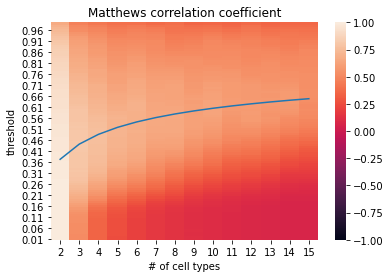

In [13]:
plot_df_mcc = total_df.groupby(["n_cell_types", "threshold"]).agg({"mcc": "mean"}).unstack(level=0)
plot_df_mcc.columns = plot_df_mcc.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_mcc, vmin=-1, vmax=1)
ax.invert_yaxis()

xs = np.array([x+2 for x in range(14)])
ys = 1 - (0.77/(xs**0.29))

plt.plot([x+0.5 for x in range(14)], ys*99)

plt.xlabel("# of cell types")
plt.title("Matthews correlation coefficient")

plt.show()

True positive rate: The higher the threshold, the less likely we are to capture the effect on the first cell type correctly

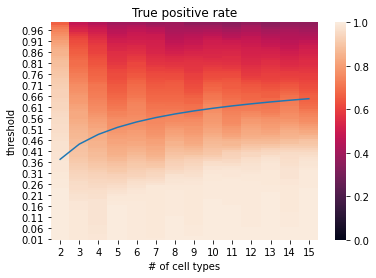

In [14]:
plot_df_tpr = total_df.groupby(["n_cell_types", "threshold"]).agg({"tpr": "mean"}).unstack(level=0)
plot_df_tpr.columns = plot_df_tpr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_tpr, vmin=0, vmax=1)
ax.invert_yaxis()

plt.plot([x+0.5 for x in range(14)], ys*99)

plt.xlabel("# of cell types")
plt.title("True positive rate")

plt.show()

True negative rate: The lower the threshold, the more likely we are to falsely assess an effect on one of the other cell types (2...K)

K=2 is an edge case, since we set the baseline to the only cell type without an effect, therefore gaining perfect TNR

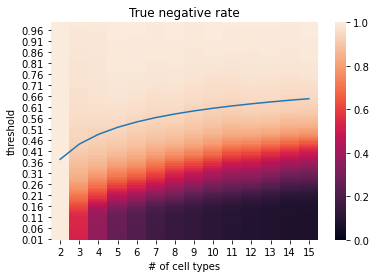

In [15]:
plot_df_tnr = total_df.groupby(["n_cell_types", "threshold"]).agg({"tnr": "mean"}).unstack(level=0)
plot_df_tnr.columns = plot_df_tnr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_tnr, vmin=0, vmax=1)
ax.invert_yaxis()

plt.plot([x+0.5 for x in range(14)], ys*99)

plt.xlabel("# of cell types")
plt.title("True negative rate")

plt.show()

False Discovery Rate: We can see the same pattern as with the other metrics.

The heatmap gives not much info, but interpolating the fdr for every K

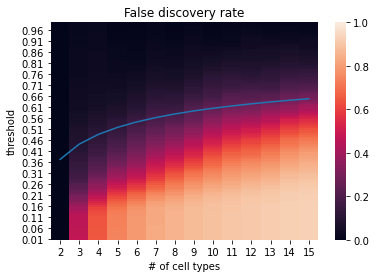

In [16]:
plot_df_fdr = total_df.groupby(["n_cell_types", "threshold"]).agg({"fdr": "mean"}).unstack(level=0)
plot_df_fdr.columns = plot_df_fdr.columns.droplevel(0)

ax = sns.heatmap(data=plot_df_fdr, vmin=0, vmax=1)
ax.invert_yaxis()

xs = np.array([x+2 for x in range(14)])
ys = 1 - (0.77/(xs**0.29))
plt.plot([x+0.5 for x in range(14)], ys*99)

plt.xlabel("# of cell types")
plt.title("False discovery rate")

plt.show()

Now determine the optimal threshold function. We suppose that the function has to be of the form $t = 1-(c/\sqrt{K})$.

To find the optimal value for c, we look at how the False Discovery Rate behaves with K.
For every K, we want to find the threshold where MCC is maximal.
Then, we fit a function to determine c for any K.

In [17]:
# Get optimal threshold  every K

# Average FDR for all K, c
grouped_df = total_df.groupby(["n_cell_types", "threshold"]).agg({"fdr": "mean", "mcc": "mean"}).reset_index()
ks = [x+2 for x in range(14)]

threshs_mcc = {}

# Find minimal threshold for every K
for k in ks:
    
    max_mcc = np.max(grouped_df.loc[grouped_df["n_cell_types"]==k, "mcc"])
    threshs_mcc[k] = np.min(grouped_df.loc[(grouped_df["n_cell_types"]==k) & (grouped_df["mcc"]==max_mcc), "threshold"])
    
print(threshs_mcc)

{2: 0.01, 3: 0.43, 4: 0.49, 5: 0.5, 6: 0.61, 7: 0.55, 8: 0.57, 9: 0.56, 10: 0.62, 11: 0.64, 12: 0.61, 13: 0.62, 14: 0.65, 15: 0.66}


Now, we determine the optimal thresholding function.
From the plot, we propose a function of the form $1 - a/(K^b); a \in (0.5, 1.5); b \in (0, 1)$.

We leave out $K=2$, since this edge case always gives an almost perfect MCC due to the baseline cell type making up half of the cell types.

We then find the optimal a and b by performing a grid search and selecting the parameter pair with the lowest sum of squared errors over all K.
The plot shows the values of optimal threshold for every K (blue) and the fitted function (orange).

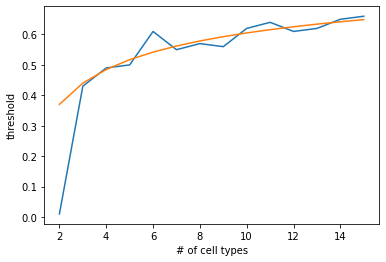

In [18]:
plt.plot(threshs_mcc.keys(), threshs_mcc.values())
plt.plot(ks, [1 - 0.77/(k**(0.29)) for k in ks])

plt.xlabel("# of cell types")
plt.ylabel("threshold")

plt.show()

In [19]:
# Leave out K=2 (edge case)
cs = np.round(np.arange(0.5, 1.5, 0.01), 2)
exps = np.round(np.arange(0.01, 1., 0.01), 2)

ssq_fdr = {}
ssq_mcc = {}

for c in cs:
    for exp in exps:
        thresh_prop = np.array([1-c/(k**exp) for k in ks[1:]])

        diffs_mcc = thresh_prop - np.fromiter(threshs_mcc.values(), dtype=float)[1:]
        ssq_mcc[(c, exp)] = np.sum(diffs_mcc**2)

min_mcc = min(ssq_mcc, key=ssq_mcc.get)

print(f"optimal parameters: a - {min_mcc[0]}, b - {min_mcc[1]}")

optimal parameters: a - 0.77, b - 0.29
